In [2]:
#Oppgave 1: Sett opp utviklingsmiljø

print("Utviklingsmiljøet er klart!")

Utviklingsmiljøet er klart!


In [93]:
#Import av alle bibliotekene vi trenger for å løse oppgavene
import requests
import os
from dotenv import load_dotenv
import pandas as pd
import missingno as msno
from pandasql import sqldf

Oppgave 2: Datainnsamling


Vi har lastet ned et datasett fra Metrologisk institutt med api og lagt det under mappen "data" i en JSON-fil. Mer informasjon står under /notebooks/README.md og /data/README.md

In [110]:
# Laster ned verdiene fra .env file
load_dotenv()

# Henter Client_id fra .env
api_key = os.getenv('API_KEY')

# definerer endpoint og parametere 
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN18700,SN90450',
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
    'referencetime': '2024-01-01/2024-12-31',
}
# Lager en HTTP GET request
r = requests.get(endpoint, parameters, auth=(api_key,''))
# Henter JSON data
json = r.json()

# Skjekker om requesten fungerte og printer ut eventuelle feil
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

# Lagrer dataen i en Dataframe i et tabellformat
df = pd.DataFrame()
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']
    df = pd.concat([df, row])

df = df.reset_index()


Data retrieved from frost.met.no!


Oppgave 3: Databehandling

For å få et bedre innblikk i hva vi har data om har vi valgt å printe noen av de første linjene, finne ut hvor mange rader vi har, sett om vi har noen manglende verdier eller duplikater, delt opp dataen med hjelp av SQL og lagt det i ulike CSV-filer.

In [114]:
#.head() printer ut de fem første  
#.head(15) printer ut de ti første linjene av datasettet    
df.head(15)

,index,elementId,value,unit,level,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId
0,0,mean(air_temperature P1D),-4.9,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2024-01-01T00:00:00.000Z,SN18700:0
1,1,mean(air_temperature P1D),-3.8,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT6H,P1D,0,C,2,NaN,2024-01-01T00:00:00.000Z,SN18700:0
2,2,sum(precipitation_amount P1D),10.4,mm,NaN,PT18H,P1D,0,C,2,NaN,2024-01-01T00:00:00.000Z,SN18700:0
3,3,sum(precipitation_amount P1D),6.3,mm,NaN,PT6H,P1D,0,C,2,0.0,2024-01-01T00:00:00.000Z,SN18700:0
4,4,mean(wind_speed P1D),6.9,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2.0,2024-01-01T00:00:00.000Z,SN18700:0
5,0,mean(air_temperature P1D),-7.4,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2024-01-02T00:00:00.000Z,SN18700:0
6,1,mean(air_temperature P1D),-5.3,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT6H,P1D,0,C,2,NaN,2024-01-02T00:00:00.000Z,SN18700:0
7,2,sum(precipitation_amount P1D),3.1,mm,NaN,PT18H,P1D,0,C,2,NaN,2024-01-02T00:00:00.000Z,SN18700:0
8,3,sum(precipitation_amount P1D),6.4,mm,NaN,PT6H,P1D,0,C,2,0.0,2024-01-02T00:00:00.000Z,SN18700:0
9,4,mean(wind_speed P1D),6.3,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2.0,2024-01-02T00:00:00.000Z,SN18700:0


In [115]:
#.shape printer ut hvor mange rader og rekker vi har
print('Shape', df.shape)

Shape (3650, 13)


<Axes: >

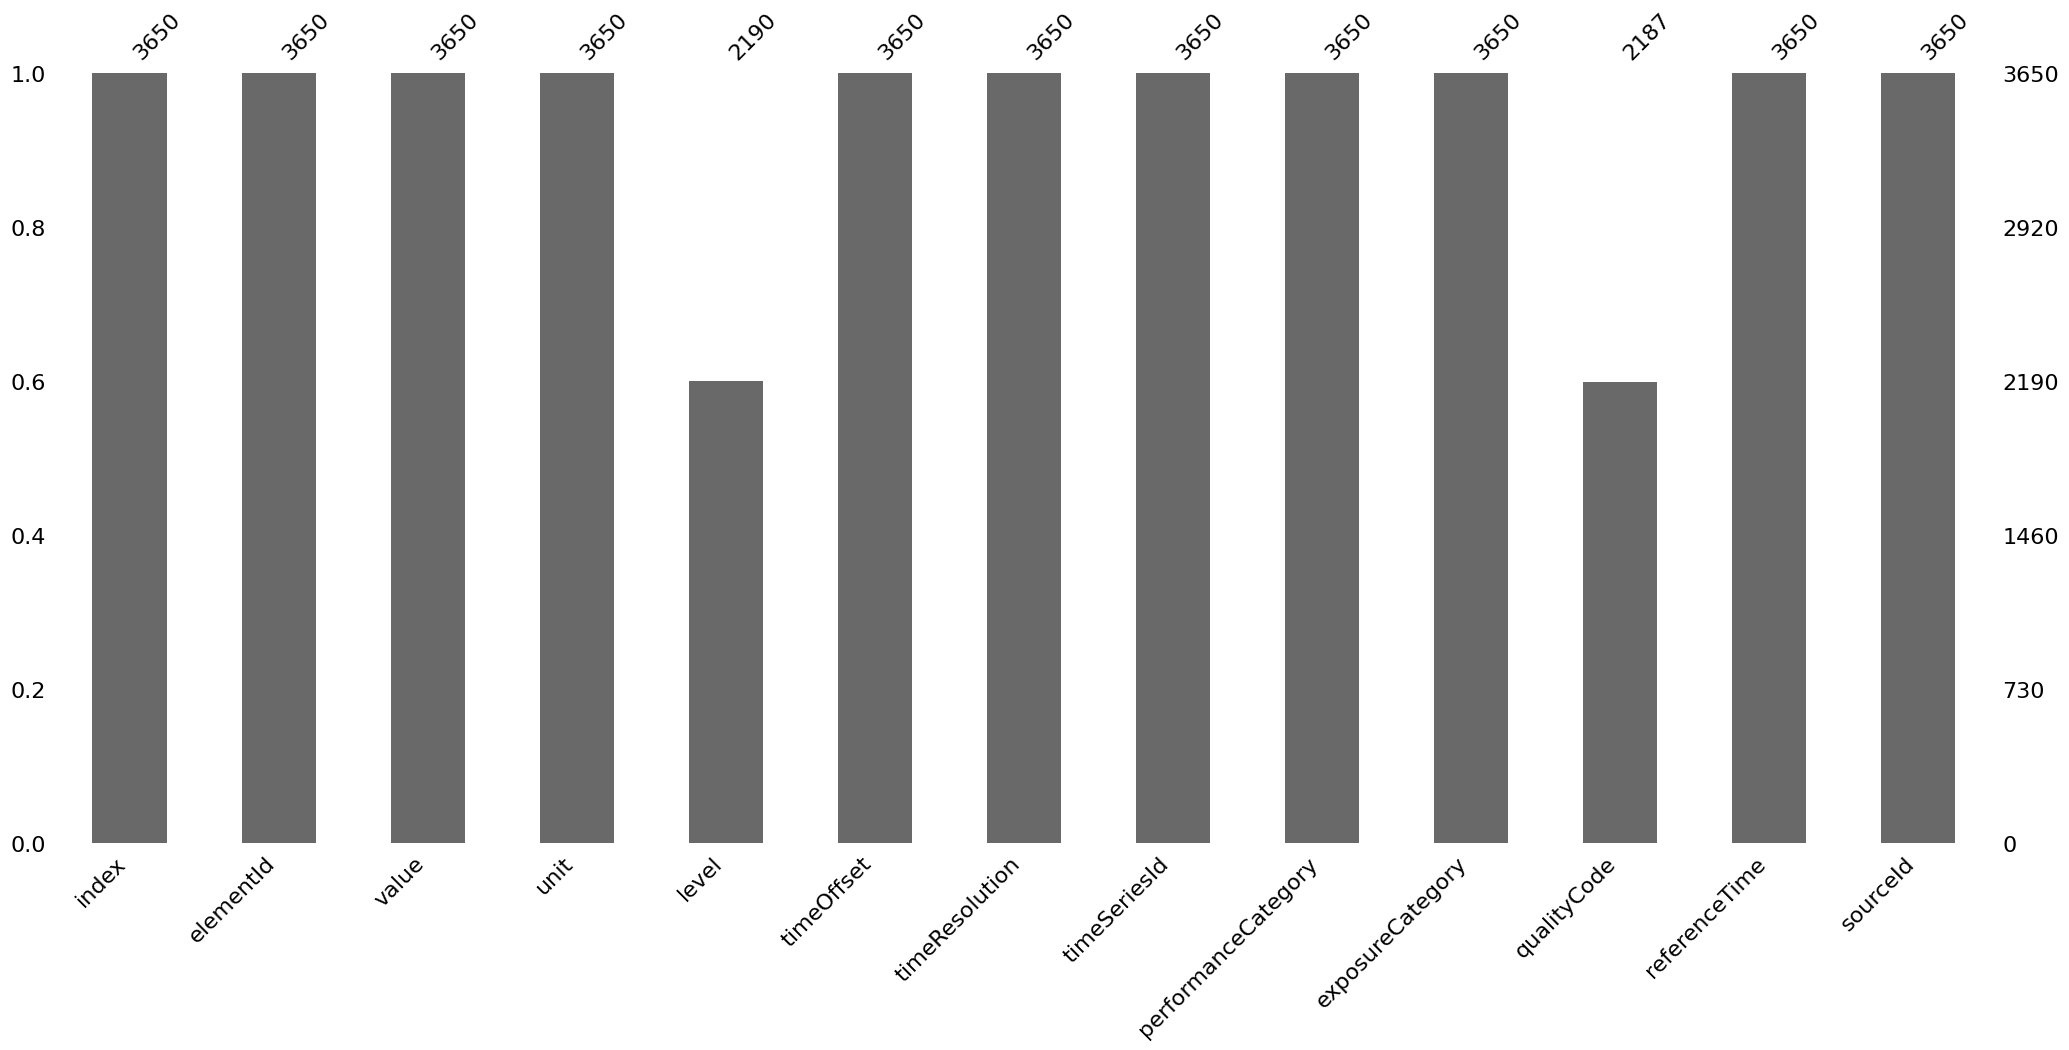

In [116]:
# Visualiserer om vi mangler noen verdier
msno.bar(df)

In [117]:
#Skjekker om vi har noen duplikater i datasettet
for i in df:
    if df.duplicated == True:
        print(i)

In [118]:
# lager en ny dataframe med utvalgte atributter
sub_df = df[["index", "elementId", "value", "unit", "timeOffset", "referenceTime"]]
sub_df

,index,elementId,value,unit,timeOffset,referenceTime
0,0,mean(air_temperature P1D),-4.9,degC,PT0H,2024-01-01T00:00:00.000Z
1,1,mean(air_temperature P1D),-3.8,degC,PT6H,2024-01-01T00:00:00.000Z
2,2,sum(precipitation_amount P1D),10.4,mm,PT18H,2024-01-01T00:00:00.000Z
3,3,sum(precipitation_amount P1D),6.3,mm,PT6H,2024-01-01T00:00:00.000Z
4,4,mean(wind_speed P1D),6.9,m/s,PT0H,2024-01-01T00:00:00.000Z
...,...,...,...,...,...,...
3645,0,mean(air_temperature P1D),0.2,degC,PT0H,2024-12-30T00:00:00.000Z
3646,1,mean(air_temperature P1D),1.0,degC,PT6H,2024-12-30T00:00:00.000Z
3647,2,sum(precipitation_amount P1D),17.0,mm,PT18H,2024-12-30T00:00:00.000Z
3648,3,sum(precipitation_amount P1D),7.1,mm,PT6H,2024-12-30T00:00:00.000Z


<Axes: >

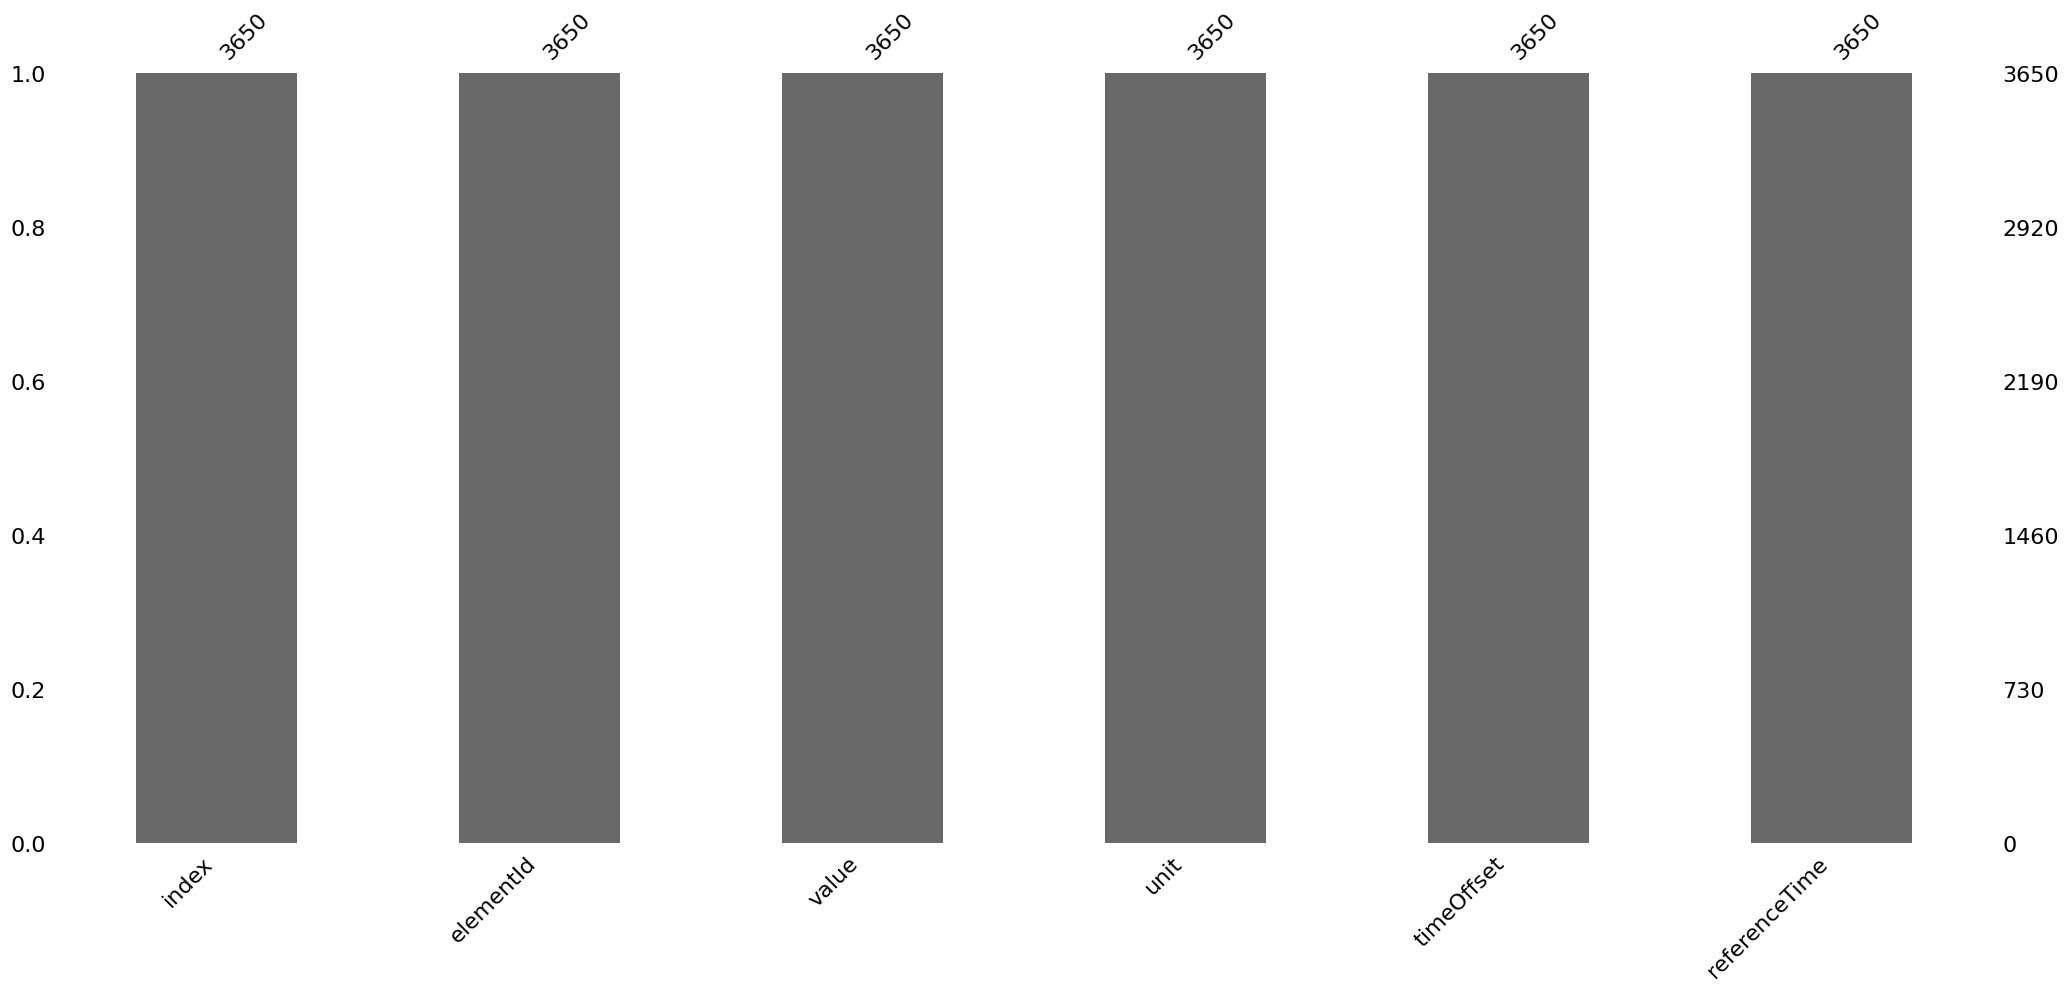

In [119]:
# Visualiserer manglende verdier i den nye dataframen
msno.bar(sub_df)

In [120]:
#bruke SQL spørringer til å hente ut bare temperatur dataene
query_temperature = f"""
    SELECT value, timeOffset, referenceTime
    FROM sub_df
    WHERE elementId LIKE 'mean(air_temperature P1D)'
    """

temperature = sqldf(query_temperature)
print(temperature)

#legger temperatur dataene til en egen csv-fil
temperature.to_csv('../data/temperature.csv', index=True)

#bruke SQL spørringer til å hente ut bare nedbør dataene
query_precipitation = f"""
    SELECT value, timeOffset, referenceTime
    FROM sub_df
    WHERE elementId LIKE 'sum(precipitation_amount P1D)'
    """

precipitation = sqldf(query_precipitation)
print(precipitation)

#legger nedbør dataene til en egen csv-fil
precipitation.to_csv('../data/precipitation.csv', index=True)



#bruke SQL spørringer til å hente ut bare vind dataene
query_wind = f"""
    SELECT value, timeOffset, referenceTime
    FROM sub_df
    WHERE elementId LIKE 'mean(wind_speed P1D)'
    """
wind = sqldf(query_wind)
print(wind)

#legger nedbør dataene til en egen csv-fil
wind.to_csv('../data/wind.csv', index=True)

      value timeOffset             referenceTime
0      -4.9       PT0H  2024-01-01T00:00:00.000Z
1      -3.8       PT6H  2024-01-01T00:00:00.000Z
2      -7.4       PT0H  2024-01-02T00:00:00.000Z
3      -5.3       PT6H  2024-01-02T00:00:00.000Z
4      -8.5       PT0H  2024-01-03T00:00:00.000Z
...     ...        ...                       ...
1455    1.1       PT6H  2024-12-28T00:00:00.000Z
1456    1.7       PT0H  2024-12-29T00:00:00.000Z
1457    2.8       PT6H  2024-12-29T00:00:00.000Z
1458    0.2       PT0H  2024-12-30T00:00:00.000Z
1459    1.0       PT6H  2024-12-30T00:00:00.000Z

[1460 rows x 3 columns]
      value timeOffset             referenceTime
0      10.4      PT18H  2024-01-01T00:00:00.000Z
1       6.3       PT6H  2024-01-01T00:00:00.000Z
2       3.1      PT18H  2024-01-02T00:00:00.000Z
3       6.4       PT6H  2024-01-02T00:00:00.000Z
4       1.2      PT18H  2024-01-03T00:00:00.000Z
...     ...        ...                       ...
1455    9.6       PT6H  2024-12-28T00:00:00.